# ELMo embedding with different Neural Networks

## Kaggle competition  [Real or Not? NLP with Disaster Tweets](https://www.kaggle.com/c/nlp-getting-started)

## Team "Muy"
### Team members: 
* **Maslennikova Elizaveta** (kaggle account - @Lizza);
* **Korobkov Nikita** (kaggle account - @Nikita Korobkov);
* **Korneva Tatyana** (kaggle account - @Tatiana Korneva).

Our team decided to apply ELMo embedding with different types of Neural Networks to task's solution.

In [1]:
# ELMo doesn't work with Tensorflow v2 on Mac OS 
# !pip install tensorflow==1.13.2

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import spacy
import sys
import copy
import os

%matplotlib inline

In [3]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [4]:
import tensorflow as trf
import tensorflow_hub as trf_hub

import keras.layers as layers
from keras import backend
from keras.layers import Input, Embedding, Flatten, BatchNormalization, LSTM, Dense, Concatenate, Bidirectional 
from keras.layers import Conv1D, MaxPooling1D, Dropout, GlobalAveragePooling1D, Reshape, GRU, GlobalMaxPooling1D
from keras.models import Model

from keras.callbacks import Callback
from sklearn.metrics import accuracy_score, log_loss, f1_score

Using TensorFlow backend.


In [5]:
sess = trf.Session(config=trf.ConfigProto(log_device_placement=True))
backend.set_session(sess)

backend.set_learning_phase(1)

sess.run(trf.global_variables_initializer())
sess.run(trf.tables_initializer())

In [8]:
# Download model for Spacy library
#!python -m spacy download en

# Data description

Explore input datasets

In [6]:
train_data = pd.read_csv('data/train.csv')
train_data.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [7]:
train_data.shape

(7613, 5)

In [8]:
train_data.describe(include=[np.number])

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [9]:
train_data.describe(include=[np.object])

,keyword,location,text
count,7552,5080,7613
unique,221,3341,7503
top,fatalities,USA,11-Year-Old Boy Charged With Manslaughter of T...
freq,45,104,10


As you can see, columns **'keyword'** and **'location'** have missed value. We fill them with special value **'Unset'**

In [10]:
train_data['keyword'] = train_data['keyword'].fillna('Unset', axis = 0)
train_data['location'] = train_data['location'].fillna('Unset', axis = 0)

In [11]:
train_data.head()

,id,keyword,location,text,target
0,1,Unset,Unset,Our Deeds are the Reason of this #earthquake M...,1
1,4,Unset,Unset,Forest fire near La Ronge Sask. Canada,1
2,5,Unset,Unset,All residents asked to 'shelter in place' are ...,1
3,6,Unset,Unset,"13,000 people receive #wildfires evacuation or...",1
4,7,Unset,Unset,Just got sent this photo from Ruby #Alaska as ...,1


In [12]:
train_data.describe(include=[np.object])

,keyword,location,text
count,7613,7613,7613
unique,222,3342,7503
top,Unset,Unset,11-Year-Old Boy Charged With Manslaughter of T...
freq,61,2533,10


Explore balance of classes in train set.

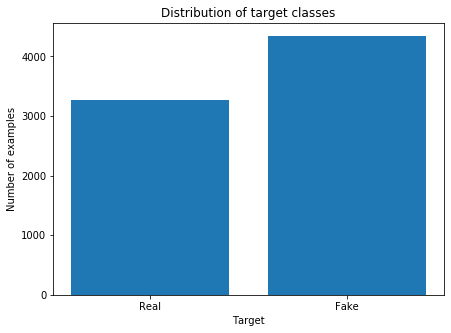

In [13]:
real_num = train_data[train_data['target'] == 1].shape[0]
fake_num = train_data[train_data['target'] == 0].shape[0]

plt.figure(figsize = (7, 5))

labels = ["Real", "Fake"]
x = np.arange(len(labels))

plt.bar(x, [real_num, fake_num])
plt.xticks(x, labels)
plt.xlabel('Target')
plt.ylabel('Number of examples')
plt.title('Distribution of target classes')
plt.show()

Dataset is balanced!

Explore length of tweets in train set.

In [14]:
disaster_len = [len(i) for i in train_data[train_data['target'] == 1]['text']]
fake_len = [len(i) for i in train_data[train_data['target'] == 0]['text']]

In [15]:
print("Max length of disaster tweets:", max(disaster_len))
print("Max length of fake tweets:", max(fake_len))

Max length of disaster tweets: 151
Max length of fake tweets: 157


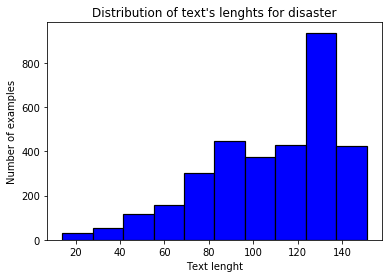

In [16]:
plt.hist(disaster_len, 10, facecolor='blue', edgecolor='black', linewidth=1.2)
plt.xlabel('Text lenght')
plt.ylabel('Number of examples')
plt.title('Distribution of text\'s lenghts for disaster')
plt.show()

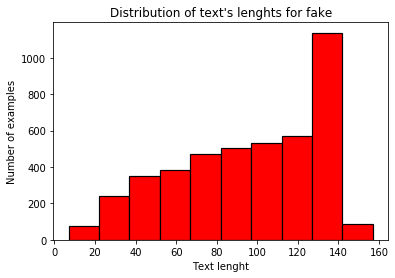

In [17]:
plt.hist(fake_len, 10, facecolor='red', edgecolor='black', linewidth=1.2)
plt.xlabel('Text lenght')
plt.ylabel('Number of examples')
plt.title('Distribution of text\'s lenghts for fake')
plt.show()

#### Let's do similar actions for test dataset:

In [18]:
test_data = pd.read_csv('data/test.csv')
test_data.head(10)

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
5,12,NaN,NaN,We're shaking...It's an earthquake
6,21,NaN,NaN,They'd probably still show more life than Arse...
7,22,NaN,NaN,Hey! How are you?
8,27,NaN,NaN,What a nice hat?
9,29,NaN,NaN,Fuck off!


In [19]:
test_data.shape

(3263, 4)

In [20]:
test_data.describe(include=[np.number])

,id
count,3263.000000
mean,5427.152927
std,3146.427221
min,0.000000
25%,2683.000000
50%,5500.000000
75%,8176.000000
max,10875.000000


In [21]:
test_data.describe(include=[np.object])

,keyword,location,text
count,3237,2158,3263
unique,221,1602,3243
top,deluged,New York,11-Year-Old Boy Charged With Manslaughter of T...
freq,23,38,3


In [22]:
test_data['keyword'] = test_data['keyword'].fillna('Unset', axis = 0)
test_data['location'] = test_data['location'].fillna('Unset', axis = 0)

In [23]:
test_data.head()

,id,keyword,location,text
0,0,Unset,Unset,Just happened a terrible car crash
1,2,Unset,Unset,"Heard about #earthquake is different cities, s..."
2,3,Unset,Unset,"there is a forest fire at spot pond, geese are..."
3,9,Unset,Unset,Apocalypse lighting. #Spokane #wildfires
4,11,Unset,Unset,Typhoon Soudelor kills 28 in China and Taiwan


In [24]:
test_data.describe(include=[np.object])

,keyword,location,text
count,3263,3263,3263
unique,222,1603,3243
top,Unset,Unset,11-Year-Old Boy Charged With Manslaughter of T...
freq,26,1105,3


In [25]:
text_len = [len(i) for i in test_data['text']]

In [26]:
print("Max length of test tweets:", max(text_len))

Max length of test tweets: 151


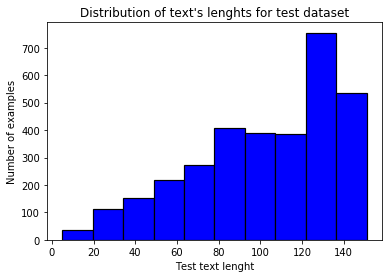

In [27]:
plt.hist(text_len, 10, facecolor='blue', edgecolor='black', linewidth=1.2)
plt.xlabel('Test text lenght')
plt.ylabel('Number of examples')
plt.title('Distribution of text\'s lenghts for test dataset')
plt.show()

In [28]:
MAX_LEN = 157

### Lifehack !

As already mentioned in other notebooks, there are full dataset with all target value in the Internet! That is why developers can deceive system using this dataset for submitting or simply for training model. We can illustrate simple example of this and get targets for test examples from full dataset:

In [29]:
full_data = pd.read_csv('data/all.csv', encoding = "ISO-8859-1")
full_data.head(5)

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,choose_one,choose_one:confidence,choose_one_gold,keyword,location,text,tweetid,userid
0,778243823,True,golden,156,NaN,Relevant,1.0000,Relevant,NaN,NaN,Just happened a terrible car crash,1.0,NaN
1,778243824,True,golden,152,NaN,Relevant,1.0000,Relevant,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,13.0,NaN
2,778243825,True,golden,137,NaN,Relevant,1.0000,Relevant,NaN,NaN,"Heard about #earthquake is different cities, s...",14.0,NaN
3,778243826,True,golden,136,NaN,Relevant,0.9603,Relevant,NaN,NaN,"there is a forest fire at spot pond, geese are...",15.0,NaN
4,778243827,True,golden,138,NaN,Relevant,1.0000,Relevant,NaN,NaN,Forest fire near La Ronge Sask. Canada,16.0,NaN


In [30]:
full_data['id'] = full_data.index
full_data['target'] = (full_data['choose_one'] == 'Relevant').astype(int)

In [31]:
full_data = full_data[['id', 'keyword', 'location', 'text', 'target']]
full_data.head(10)

,id,keyword,location,text,target
0,0,NaN,NaN,Just happened a terrible car crash,1
1,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
2,2,NaN,NaN,"Heard about #earthquake is different cities, s...",1
3,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",1
4,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
5,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
6,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
7,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
8,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
9,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,1


In [32]:
real_true = pd.merge(test_data, full_data, on='id')
real_true.head()

,id,keyword_x,location_x,text_x,keyword_y,location_y,text_y,target
0,0,Unset,Unset,Just happened a terrible car crash,NaN,NaN,Just happened a terrible car crash,1
1,2,Unset,Unset,"Heard about #earthquake is different cities, s...",NaN,NaN,"Heard about #earthquake is different cities, s...",1
2,3,Unset,Unset,"there is a forest fire at spot pond, geese are...",NaN,NaN,"there is a forest fire at spot pond, geese are...",1
3,9,Unset,Unset,Apocalypse lighting. #Spokane #wildfires,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,1
4,11,Unset,Unset,Typhoon Soudelor kills 28 in China and Taiwan,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,1


In [33]:
to_submit = real_true[['id', 'target']]
to_submit.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [34]:
real_true.to_csv('result/real_true.csv', index=False)

#### Of course, we got F1-score = 1!

<img src="result/real_true_sub.png">

#### But it is unfaithful and not interesting for true developers! :)

### Let's begin implementation of our model

We create test dataset (from this full version) with true targets value ONLY for testing our models during the training process!!!

In [35]:
test_data_new = real_true[['id', 'target', 'keyword_x', 'location_x', 'text_x']]
test_data_new.head()

,id,target,keyword_x,location_x,text_x
0,0,1,Unset,Unset,Just happened a terrible car crash
1,2,1,Unset,Unset,"Heard about #earthquake is different cities, s..."
2,3,1,Unset,Unset,"there is a forest fire at spot pond, geese are..."
3,9,1,Unset,Unset,Apocalypse lighting. #Spokane #wildfires
4,11,1,Unset,Unset,Typhoon Soudelor kills 28 in China and Taiwan


In [36]:
test_data_new = test_data_new.rename(columns={"keyword_x": "keyword", "location_x": "location", "text_x": "text"})
test_data_new.head()

,id,target,keyword,location,text
0,0,1,Unset,Unset,Just happened a terrible car crash
1,2,1,Unset,Unset,"Heard about #earthquake is different cities, s..."
2,3,1,Unset,Unset,"there is a forest fire at spot pond, geese are..."
3,9,1,Unset,Unset,Apocalypse lighting. #Spokane #wildfires
4,11,1,Unset,Unset,Typhoon Soudelor kills 28 in China and Taiwan


# Clearing text and preparing data

We try different types of text's clearing, but it is the best.

We delete punctuation, spaces, special symbols ($, \%, §, ©, +, −, ×, ÷, =, :), 😝) and numeral using Spacy library.

In [37]:
def clearing_data(data):
    model_lingv = spacy.load("en")
    discard = {'PUNCT','SPACE','SYM','NUM'}

    processed_text = []

    n = len(data["text"])
    for i in range(0, n):
        text = data["text"][i]
        text = text.lower()
        doc = model_lingv(text)
        words = []
        for w in doc:
            if w.pos_ not in discard and not w.like_email and not w.like_url and not w.like_num:
                words.append(w.string)
        t = ' '.join(words)
        processed_text.append(t)

        sys.stdout.write("\r%f%%" % (100*(i+1)/n))
        sys.stdout.flush()

    data["clearing_text"] = processed_text
    return data

In [38]:
train_data = clearing_data(train_data)
print("\nTrain data was clearing!")
test_data_new = clearing_data(test_data_new)
print("\nTest data was clearing!")

100.000000%
Train data was clearing!
100.000000%
Test data was clearing!


In [39]:
train_data.head()

,id,keyword,location,text,target,clearing_text
0,1,Unset,Unset,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this # eart...
1,4,Unset,Unset,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,5,Unset,Unset,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place ...
3,6,Unset,Unset,"13,000 people receive #wildfires evacuation or...",1,people receive # wildfires evacuation orde...
4,7,Unset,Unset,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby alas...


In [40]:
test_data_new.head()

,id,target,keyword,location,text,clearing_text
0,0,1,Unset,Unset,Just happened a terrible car crash,just happened a terrible car crash
1,2,1,Unset,Unset,"Heard about #earthquake is different cities, s...",heard about earthquake is different citie...
2,3,1,Unset,Unset,"there is a forest fire at spot pond, geese are...",there is a forest fire at spot pond gee...
3,9,1,Unset,Unset,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting # spokane # wildfires
4,11,1,Unset,Unset,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kills in china and taiwan


Get tweet's text and labels from train and test datasets

In [41]:
def prepare_data(data, test=False, max_text_lenth = MAX_LEN):
    text = data['clearing_text'].tolist()
    text = [' '.join(t.split()[0:max_text_lenth]) for t in text]
    text = np.array(text)
    
    label = []
    if not test:
        label = data['target'].tolist()
    return text, label

In [42]:
train_text, train_label = prepare_data(train_data)
test_text, test_label = prepare_data(test_data_new)

# Building and training models

### There are explorations of different type of Neural Networks in this Notebook

## Fully-Connected Neural Netrworks 

First of all, let's try to train **Neural Network** consisting of **Elmo embedding (with Normalization)** and **3  fully-connected layers**

In [43]:
# Get ELMo model
def make_elmo_embedding(x):
    elmo_module = trf_hub.Module("https://tfhub.dev/google/elmo/3", trainable=True)
    embeddings = elmo_module(trf.squeeze(trf.cast(x, trf.string)), signature="default", as_dict=True)["default"]
    
    return embeddings

In [44]:
# Class for calculating F1-score after every epoch
class Metrics(Callback):
        
    def on_epoch_end(self, epoch, logs={}):
        val_predict = (np.asarray(self.model.predict(self.validation_data[0]))).round()
        val_targ = self.validation_data[1]
        _val_f1 = f1_score(val_targ, val_predict)
        print("F1:", _val_f1)
        return

In [45]:
metrics = Metrics()

In [46]:
def build_model():
    input_text = layers.Input(shape=(1, ), dtype=trf.string)
    
    elmo_embedding = layers.Lambda(make_elmo_embedding, output_shape=(1024,))(input_text)
    
    word_embedding = BatchNormalization()(elmo_embedding)
    
    x = Dense(128, activation='relu')(word_embedding)
    x2 = Dense(64, activation='relu')(x)
    
    predict = Dense(units = 1, activation='sigmoid')(x2)
    
    model = Model(inputs=[input_text], outputs=predict)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
  
    return model

In [47]:
model = build_model()

Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [48]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 1024)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024)              4096      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               131200    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 143,617
Trainable params: 141,569
Non-trainable params: 2,048
_________________________________________________________________


We will save weights of model after every epoch to avoid retraining of the model

In [72]:
MODEL_FOLDER = 'ELMo_FC_v1'
os.mkdir(MODEL_FOLDER)

In [75]:
def train(model, init_epoch, end_epoch):
    history = model.fit(train_text, train_label, validation_data=(test_text, test_label), initial_epoch = init_epoch, epochs=end_epoch, callbacks=[metrics])
    new_folder_name = 'after_' + str(end_epoch) + '_epoch'
    os.mkdir(os.path.join(MODEL_FOLDER, new_folder_name))
    model.save_weights(os.path.join(MODEL_FOLDER, new_folder_name + '_.h5'))
    return model

Let's try training!

In [76]:
for i in range(1, 9):
    model = train(model, i-1, i)

Train on 7613 samples, validate on 3263 samples
Epoch 1/1
7613/7613 [==============================] - 913s 120ms/step - loss: 0.4627 - acc: 0.7918 - val_loss: 0.5240 - val_acc: 0.7542
F1: 0.6718494271685762
Train on 7613 samples, validate on 3263 samples
Epoch 2/2
7613/7613 [==============================] - 902s 118ms/step - loss: 0.3533 - acc: 0.8520 - val_loss: 0.5343 - val_acc: 0.7561
F1: 0.6924265842349303
Train on 7613 samples, validate on 3263 samples
Epoch 3/3
7613/7613 [==============================] - 940s 123ms/step - loss: 0.2943 - acc: 0.8767 - val_loss: 0.5693 - val_acc: 0.7469
F1: 0.6954277286135693
Train on 7613 samples, validate on 3263 samples
Epoch 4/4
7613/7613 [==============================] - 919s 121ms/step - loss: 0.2413 - acc: 0.9040 - val_loss: 0.5985 - val_acc: 0.7499
F1: 0.6880733944954128
Train on 7613 samples, validate on 3263 samples
Epoch 5/5
7613/7613 [==============================] - 938s 123ms/step - loss: 0.1916 - acc: 0.9271 - val_loss: 0.6844 -

Moreover, we can try to find list of keywords which indicate disaster most likely and immediately mark them as disaster. We will save both versions from model and artificially corrected.

In [49]:
# Thank you for idea https://www.kaggle.com/dmitri9149/transformer-svm-semantically-identical-tweets/notebook
aggregation = copy.deepcopy(train_data)

aggregation = aggregation.groupby('keyword').agg({'target':np.mean}).rename(columns={'target':'keyword_prob'})
aggregation = aggregation.sort_values('keyword_prob', ascending=False).head(20)

min_prob = 0.95
keyword_disaster = list(aggregation[aggregation['keyword_prob'] >= min_prob].index)
keyword_disaster

['wreckage',
 'debris',
 'derailment',
 'outbreak',
 'oil%20spill',
 'typhoon',
 'suicide%20bombing',
 'suicide%20bomber']

In [50]:
# Function for saving model
def save_result(best_epoch):
    new_file_name = 'after_' + str(best_epoch) + '_epoch'
    model = build_model()
    model.load_weights(os.path.join(MODEL_FOLDER, new_file_name, new_file_name + '_.h5'))
    
    predict_label = np.asarray(model.predict(test_text, verbose=1)).round()
    predict_label = predict_label.astype(int)
    
    for_submit = copy.deepcopy(test_data)
    for_submit["target"] = predict_label
    for_submit = for_submit[['id', 'target']]
    
    file_name = 'submit_' + MODEL_FOLDER + '.csv'
    for_submit.to_csv('result/' + file_name, index=False)
    
    # Do correction    
    for_submit = copy.deepcopy(test_data)
    for_submit["target"] = predict_label
    id_to_change = for_submit['id'][for_submit['keyword'].isin(keyword_disaster)].values
    for_submit['target'][for_submit['id'].isin(id_to_change)] = 1
    for_submit = for_submit[['id', 'target']]
    file_name = 'submit_' + MODEL_FOLDER + '_corrected.csv'
    for_submit.to_csv('result/' + file_name, index=False)

In [89]:
save_result(best_epoch = 7)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


3263/3263 [==============================] - 311s 95ms/step


Submition score = 0.73312:
<img src="result/submit_ELMo_FC_v1_sub.png">

Submition score after correction = 0.73517:
<img src="result/submit_ELMo_FC_v1_cor_sub.png">

Now let's try to train **Neural Network** consisting of **Elmo embedding (with Normalization)** and **4  fully-connected layers** with more neurons

In [134]:
def build_model():
    input_text = layers.Input(shape=(None, ), dtype=trf.string)
    
    elmo_embedding = layers.Lambda(make_elmo_embedding, output_shape=(1024,))(input_text)
    
    word_embedding = BatchNormalization()(elmo_embedding)
    
    x = Dense(512, activation='relu')(word_embedding)
    x2 = Dense(256, activation='relu')(x)
    x3 = Dense(64, activation='relu')(x2)
    
    predict = Dense(units = 1, activation='sigmoid')(x3)
    
    model = Model(inputs=[input_text], outputs=predict)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
  
    return model

In [135]:
model = build_model()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [136]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        (None, None)              0         
_________________________________________________________________
lambda_19 (Lambda)           (None, 1024)              0         
_________________________________________________________________
batch_normalization_19 (Batc (None, 1024)              4096      
_________________________________________________________________
dense_40 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_41 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_42 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_43 (Dense)             (None, 1)                 65        
Total para

In [93]:
MODEL_FOLDER = 'ELMo_FC_v2'
os.mkdir(MODEL_FOLDER)

In [94]:
def train(model, init_epoch, end_epoch):
    history = model.fit(train_text, train_label, validation_data=(test_text, test_label), initial_epoch = init_epoch, epochs=end_epoch, callbacks=[metrics])
    new_file_name = 'after_' + str(end_epoch) + '_epoch'
    model.save_weights(os.path.join(MODEL_FOLDER, new_file_name + '_.h5'))
    return model

In [96]:
for i in range(1, 9):
    model = train(model, i-1, i)

Train on 7613 samples, validate on 3263 samples
Epoch 1/1
7613/7613 [==============================] - 968s 127ms/step - loss: 0.3794 - acc: 0.8344 - val_loss: 0.5219 - val_acc: 0.7613
F1: 0.7081303859123267
Train on 7613 samples, validate on 3263 samples
Epoch 2/2
7613/7613 [==============================] - 996s 131ms/step - loss: 0.3342 - acc: 0.8616 - val_loss: 0.5445 - val_acc: 0.7432
F1: 0.6905465288035451
Train on 7613 samples, validate on 3263 samples
Epoch 3/3
7613/7613 [==============================] - 1105s 145ms/step - loss: 0.2835 - acc: 0.8845 - val_loss: 0.5864 - val_acc: 0.7349
F1: 0.7024423804609564
Train on 7613 samples, validate on 3263 samples
Epoch 4/4
7613/7613 [==============================] - 1014s 133ms/step - loss: 0.2373 - acc: 0.9042 - val_loss: 0.6555 - val_acc: 0.7318
F1: 0.7012632297712531
Train on 7613 samples, validate on 3263 samples
Epoch 5/5
7613/7613 [==============================] - 1120s 147ms/step - loss: 0.1943 - acc: 0.9242 - val_loss: 0.714

In [137]:
MODEL_FOLDER = 'ELMo_FC_v2'
save_result(best_epoch=6)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


3263/3263 [==============================] - 298s 91ms/step


## Convolution Neural Networks

Now let's try to train **Convolution Neural Network** with **Elmo embedding (with Normalization)**

In [51]:
def make_elmo_embedding(x):
    elmo_module = trf_hub.Module("https://tfhub.dev/google/elmo/3", trainable=True)
    embeddings = elmo_module(trf.squeeze(trf.cast(x, trf.string)), signature="default", as_dict=True)["elmo"]
    
    return embeddings

In [139]:
def build_model():
    input_text = layers.Input(shape=(None, ), dtype=trf.string)
    
    elmo_embedding = layers.Lambda(make_elmo_embedding, output_shape=(None, 1024))(input_text)
    
    word_embedding = BatchNormalization()(elmo_embedding)

    x = Conv1D(128, 5, activation='relu')(word_embedding)
    x2 = GlobalMaxPooling1D()(x)
    x3 = Dense(10, activation='relu')(x2)
    
    predict = Dense(units = 1, activation='sigmoid')(x3)
    
    model = Model(inputs=[input_text], outputs=predict)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
  
    return model

In [140]:
model = build_model()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [141]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        (None, None)              0         
_________________________________________________________________
lambda_21 (Lambda)           (None, None, 1024)        0         
_________________________________________________________________
batch_normalization_21 (Batc (None, None, 1024)        4096      
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 128)         655488    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 128)               0         
_________________________________________________________________
dense_48 (Dense)             (None, 10)                1290      
_________________________________________________________________
dense_49 (Dense)             (None, 1)                 11        
Total para

In [101]:
MODEL_FOLDER = 'ELMo_Convolution_v1'
if os.path.exists(MODEL_FOLDER):
    os.removedirs(MODEL_FOLDER)
os.mkdir(MODEL_FOLDER)

In [102]:
def train(model, init_epoch, end_epoch):
    history = model.fit(train_text, train_label, validation_data=(test_text, test_label), initial_epoch = init_epoch, epochs=end_epoch, callbacks=[metrics])
    new_folder_name = 'after_' + str(end_epoch) + '_epoch'
    os.mkdir(os.path.join(MODEL_FOLDER, new_folder_name))
    model.save_weights(os.path.join(MODEL_FOLDER, new_folder_name + '_.h5'))
    return model

In [103]:
for i in range(1, 11):
    model = train(model, i-1, i)

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


Train on 7613 samples, validate on 3263 samples
Epoch 1/1
7613/7613 [==============================] - 942s 124ms/step - loss: 0.4880 - acc: 0.7847 - val_loss: 0.4673 - val_acc: 0.7879
F1: 0.7446494464944649
Train on 7613 samples, validate on 3263 samples
Epoch 2/2
7613/7613 [==============================] - 929s 122ms/step - loss: 0.3271 - acc: 0.8534 - val_loss: 0.4990 - val_acc: 0.7867
F1: 0.7373584905660376
Train on 7613 samples, validate on 3263 samples
Epoch 3/3
7613/7613 [==============================] - 941s 124ms/step - loss: 0.2473 - acc: 0.8874 - val_loss: 0.5487 - val_acc: 0.7876
F1: 0.7251090836969456
Train on 7613 samples, validate on 3263 samples
Epoch 4/4
7613/7613 [==============================] - 956s 126ms/step - loss: 0.1673 - acc: 0.9266 - val_loss: 0.5658 - val_acc: 0.7754
F1: 0.7386809269162209
Train on 7613 samples, validate on 3263 samples
Epoch 5/5
7613/7613 [==============================] - 955s 125ms/step - loss: 0.1343 - acc: 0.9398 - val_loss: 0.6560 -

In [144]:
MODEL_FOLDER = 'ELMo_Convolution_v1'
save_result(best_epoch=8)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


3263/3263 [==============================] - 308s 95ms/step


Now let's try to train deeply **Convolution Neural Network** with **Elmo embedding (with Normalization)**

In [145]:
def build_model():
    input_text = layers.Input(shape=(None, ), dtype=trf.string)
    
    elmo_embedding = layers.Lambda(make_elmo_embedding, output_shape=(None, 1024))(input_text)
    
    word_embedding = BatchNormalization()(elmo_embedding)

    x = Conv1D(256, 5, activation='relu')(word_embedding)
    x2 = MaxPooling1D(3)(x)
    x3 = Conv1D(128, 3, activation='relu')(x2)
    x4 = GlobalAveragePooling1D()(x3)
    x5 = Dropout(0.5)(x4)
    
    predict = Dense(units = 1, activation='sigmoid')(x5)
    
    model = Model(inputs=[input_text], outputs=predict)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
  
    return model

In [146]:
model = build_model()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [147]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        (None, None)              0         
_________________________________________________________________
lambda_24 (Lambda)           (None, None, 1024)        0         
_________________________________________________________________
batch_normalization_24 (Batc (None, None, 1024)        4096      
_________________________________________________________________
conv1d_7 (Conv1D)            (None, None, 256)         1310976   
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, None, 256)         0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, None, 128)         98432     
_________________________________________________________________
global_average_pooling1d_2 ( (None, 128)               0         
__________

In [107]:
MODEL_FOLDER = 'ELMo_Convolution_v2'
if os.path.exists(MODEL_FOLDER):
    os.removedirs(MODEL_FOLDER)
os.mkdir(MODEL_FOLDER)

In [108]:
def train(model, init_epoch, end_epoch):
    history = model.fit(train_text, train_label, validation_data=(test_text, test_label), initial_epoch = init_epoch, epochs=end_epoch, callbacks=[metrics])
    new_folder_name = 'after_' + str(end_epoch) + '_epoch'
    os.mkdir(os.path.join(MODEL_FOLDER, new_folder_name))
    model.save_weights(os.path.join(MODEL_FOLDER, new_folder_name + '_.h5'))
    return model

In [109]:
for i in range(1, 11):
    model = train(model, i-1, i)

Train on 7613 samples, validate on 3263 samples
Epoch 1/1
7613/7613 [==============================] - 1012s 133ms/step - loss: 0.5274 - acc: 0.7729 - val_loss: 0.4979 - val_acc: 0.7769
F1: 0.7031772575250836
Train on 7613 samples, validate on 3263 samples
Epoch 2/2
7613/7613 [==============================] - 980s 129ms/step - loss: 0.4199 - acc: 0.8233 - val_loss: 0.4987 - val_acc: 0.7898
F1: 0.7170751973410886
Train on 7613 samples, validate on 3263 samples
Epoch 3/3
7613/7613 [==============================] - 979s 129ms/step - loss: 0.3748 - acc: 0.8484 - val_loss: 0.5339 - val_acc: 0.7536
F1: 0.7174066243833687
Train on 7613 samples, validate on 3263 samples
Epoch 4/4
7613/7613 [==============================] - 984s 129ms/step - loss: 0.3347 - acc: 0.8667 - val_loss: 0.5830 - val_acc: 0.7971
F1: 0.745917204709457
Train on 7613 samples, validate on 3263 samples
Epoch 5/5
7613/7613 [==============================] - 993s 130ms/step - loss: 0.2829 - acc: 0.8860 - val_loss: 0.6749 -

In [148]:
MODEL_FOLDER = 'ELMo_Convolution_v2'
save_result(best_epoch=7)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


3263/3263 [==============================] - 299s 92ms/step


## Reccurent Neural Network

Let's try to train **Recccurant Neural Network** with **Elmo embedding (with Normalization)** and **Bidirectional LSTM** layer

In [52]:
def build_model(): 
    input_text = layers.Input(shape=(None, ), dtype=trf.string)
    
    elmo_embedding = layers.Lambda(make_elmo_embedding, output_shape=(None, 1024))(input_text)
    
    word_embedding = BatchNormalization()(elmo_embedding)
    x2 = Bidirectional(LSTM(256, dropout=0.2, recurrent_dropout=0.2))(word_embedding)
    predict = Dense(units=1, activation='sigmoid')(x2)


    model = Model(inputs=[input_text], outputs=predict)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
  
    return model

In [53]:
model = build_model()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [54]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None)              0         
_________________________________________________________________
lambda_2 (Lambda)            (None, None, 1024)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, None, 1024)        4096      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 512)               2623488   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 513       
Total params: 2,628,097
Trainable params: 2,626,049
Non-trainable params: 2,048
_________________________________________________________________


In [113]:
MODEL_FOLDER = 'ELMo_BiLSTM_v1'
if os.path.exists(MODEL_FOLDER):
    os.removedirs(MODEL_FOLDER)
os.mkdir(MODEL_FOLDER)

In [114]:
def train(model, init_epoch, end_epoch):
#     TB = TensorBoard(histogram_freq=0)
    history = model.fit(train_text, train_label, validation_data=(test_text, test_label), initial_epoch = init_epoch, epochs=end_epoch, callbacks=[metrics])
    new_folder_name = 'after_' + str(end_epoch) + '_epoch'
    os.mkdir(os.path.join(MODEL_FOLDER, new_folder_name))
    model.save_weights(os.path.join(MODEL_FOLDER, new_folder_name + '_.h5'))
    return model

In [115]:
for i in range(1, 11):
    model = train(model, i-1, i)

Train on 7613 samples, validate on 3263 samples
Epoch 1/1
7613/7613 [==============================] - 1060s 139ms/step - loss: 0.4556 - acc: 0.7935 - val_loss: 0.4341 - val_acc: 0.8066
F1: 0.7577260587561998
Train on 7613 samples, validate on 3263 samples
Epoch 2/2
7613/7613 [==============================] - 1025s 135ms/step - loss: 0.3294 - acc: 0.8618 - val_loss: 0.4537 - val_acc: 0.8029
F1: 0.738244514106583
Train on 7613 samples, validate on 3263 samples
Epoch 3/3
7613/7613 [==============================] - 1039s 136ms/step - loss: 0.2398 - acc: 0.9070 - val_loss: 0.4948 - val_acc: 0.7968
F1: 0.748646558391338
Train on 7613 samples, validate on 3263 samples
Epoch 4/4
7613/7613 [==============================] - 1037s 136ms/step - loss: 0.1720 - acc: 0.9391 - val_loss: 0.5551 - val_acc: 0.7888
F1: 0.7462467960454047
Train on 7613 samples, validate on 3263 samples
Epoch 5/5
7613/7613 [==============================] - 1029s 135ms/step - loss: 0.1299 - acc: 0.9547 - val_loss: 0.581

In [55]:
MODEL_FOLDER = 'ELMo_BiLSTM_v1'
save_result(best_epoch=7)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


3263/3263 [==============================] - 292s 89ms/step


Let's try to train deeply **Recccurant Neural Network** with **Elmo embedding (with Normalization)** and **2 Bidirectional LSTM** layers

In [56]:
def build_model(): 
    input_text = layers.Input(shape=(None, ), dtype=trf.string)
    
    elmo_embedding = layers.Lambda(make_elmo_embedding, output_shape=(None, 1024))(input_text)
    
    word_embedding = BatchNormalization()(elmo_embedding)
    x = Bidirectional(LSTM(256, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))(word_embedding)
    x2 = Bidirectional(LSTM(256, dropout=0.2, recurrent_dropout=0.2))(x)
    predict = Dense(units=1, activation='sigmoid')(x2)


    model = Model(inputs=[input_text], outputs=predict)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
  
    return model

In [57]:
model = build_model()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [58]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, None)              0         
_________________________________________________________________
lambda_4 (Lambda)            (None, None, 1024)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, None, 1024)        4096      
_________________________________________________________________
bidirectional_3 (Bidirection (None, None, 512)         2623488   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 512)               1574912   
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 513       
Total params: 4,203,009
Trainable params: 4,200,961
Non-trainable params: 2,048
______________________________________________________________

In [119]:
MODEL_FOLDER = 'ELMo_BiLSTM_v2'
if os.path.exists(MODEL_FOLDER):
    os.removedirs(MODEL_FOLDER)
os.mkdir(MODEL_FOLDER)

In [120]:
def train(model, init_epoch, end_epoch):
    history = model.fit(train_text, train_label, validation_data=(test_text, test_label), initial_epoch = init_epoch, epochs=end_epoch, callbacks=[metrics])
    new_folder_name = 'after_' + str(end_epoch) + '_epoch'
    os.mkdir(os.path.join(MODEL_FOLDER, new_folder_name))
    model.save_weights(os.path.join(MODEL_FOLDER, new_folder_name + '_.h5'))
    return model

In [121]:
for i in range(1, 11):
    model = train(model, i-1, i)

Train on 7613 samples, validate on 3263 samples
Epoch 1/1
7613/7613 [==============================] - 1298s 171ms/step - loss: 0.4558 - acc: 0.7999 - val_loss: 0.4525 - val_acc: 0.7990
F1: 0.7347104090724991
Train on 7613 samples, validate on 3263 samples
Epoch 2/2
7613/7613 [==============================] - 1248s 164ms/step - loss: 0.3573 - acc: 0.8525 - val_loss: 0.4667 - val_acc: 0.7990
F1: 0.7353896103896104
Train on 7613 samples, validate on 3263 samples
Epoch 3/3
7613/7613 [==============================] - 1205s 158ms/step - loss: 0.2910 - acc: 0.8824 - val_loss: 0.4953 - val_acc: 0.7864
F1: 0.7482439926062846
Train on 7613 samples, validate on 3263 samples
Epoch 4/4
7613/7613 [==============================] - 1287s 169ms/step - loss: 0.2175 - acc: 0.9149 - val_loss: 0.5769 - val_acc: 0.7824
F1: 0.7385171790235082
Train on 7613 samples, validate on 3263 samples
Epoch 5/5
7613/7613 [==============================] - 1290s 170ms/step - loss: 0.1730 - acc: 0.9320 - val_loss: 0.6

In [59]:
MODEL_FOLDER = 'ELMo_BiLSTM_v2'
save_result(best_epoch=3)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


3263/3263 [==============================] - 302s 93ms/step


Let's try to train deeply **Recccurant Neural Network** with **Elmo embedding (with Normalization)** and **3 Bidirectional LSTM** layers with more neurons

In [60]:
def build_model(): 
    input_text = layers.Input(shape=(None, ), dtype=trf.string)
    
    elmo_embedding = layers.Lambda(make_elmo_embedding, output_shape=(None, 1024))(input_text)
    
    word_embedding = BatchNormalization()(elmo_embedding)
    x = Bidirectional(LSTM(512, dropout=0.3, recurrent_dropout=0.3, return_sequences=True))(word_embedding)
    x2 = Bidirectional(LSTM(256, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))(x)
    x3 = Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2))(x2)
    predict = Dense(units=1, activation='sigmoid')(x3)


    model = Model(inputs=[input_text], outputs=predict)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
  
    return model

In [61]:
model = build_model()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [62]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, None)              0         
_________________________________________________________________
lambda_6 (Lambda)            (None, None, 1024)        0         
_________________________________________________________________
batch_normalization_6 (Batch (None, None, 1024)        4096      
_________________________________________________________________
bidirectional_7 (Bidirection (None, None, 1024)        6295552   
_________________________________________________________________
bidirectional_8 (Bidirection (None, None, 512)         2623488   
_________________________________________________________________
bidirectional_9 (Bidirection (None, 256)               656384    
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 257       
Total para

In [125]:
MODEL_FOLDER = 'ELMo_BiLSTM_v3'
if os.path.exists(MODEL_FOLDER):
    os.removedirs(MODEL_FOLDER)
os.mkdir(MODEL_FOLDER)

In [126]:
def train(model, init_epoch, end_epoch):
    history = model.fit(train_text, train_label, validation_data=(test_text, test_label), initial_epoch = init_epoch, epochs=end_epoch, callbacks=[metrics])
    new_folder_name = 'after_' + str(end_epoch) + '_epoch'
    os.mkdir(os.path.join(MODEL_FOLDER, new_folder_name))
    model.save_weights(os.path.join(MODEL_FOLDER, new_folder_name + '_.h5'))
    return model

In [127]:
for i in range(1, 11):
    model = train(model, i-1, i)

Train on 7613 samples, validate on 3263 samples
Epoch 1/1
7613/7613 [==============================] - 1319s 173ms/step - loss: 0.4567 - acc: 0.7990 - val_loss: 0.4535 - val_acc: 0.7996
F1: 0.7347266881028939
Train on 7613 samples, validate on 3263 samples
Epoch 2/2
7613/7613 [==============================] - 1570s 206ms/step - loss: 0.3835 - acc: 0.8380 - val_loss: 0.4769 - val_acc: 0.7962
F1: 0.7593466424682396
Train on 7613 samples, validate on 3263 samples
Epoch 3/3
7613/7613 [==============================] - 1363s 179ms/step - loss: 0.3275 - acc: 0.8621 - val_loss: 0.4768 - val_acc: 0.7996
F1: 0.7371360191463902
Train on 7613 samples, validate on 3263 samples
Epoch 4/4
7613/7613 [==============================] - 1318s 173ms/step - loss: 0.2601 - acc: 0.8933 - val_loss: 0.5053 - val_acc: 0.7797
F1: 0.7372549019607844
Train on 7613 samples, validate on 3263 samples
Epoch 5/5
7613/7613 [==============================] - 1184s 155ms/step - loss: 0.2150 - acc: 0.9141 - val_loss: 0.5

In [63]:
MODEL_FOLDER = 'ELMo_BiLSTM_v3'
save_result(best_epoch=2)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


3263/3263 [==============================] - 302s 93ms/step


## Results

As we can see, Recurrent Neural Network with 3 BiLSTM layers showed the best F1-score. That is why we submit this result on the site. But during the training process we saved models' weights and we can reproduce any result.

### Submittion score of ELMo_BiLSTM_v3 model is:

Submition score = 0.77402:
<img src="result/submit_BiLSTM_v3.png">
Submition score after corrected = 0.77607:
<img src="result/submit_BiLSTM_v3_cor.png">

# Thank you for attantion to our work!